# `Материалы кафедры ММП факультета ВМК МГУ. Введение в глубокое обучение.`

## `Задание 3.5. Трансформеры для Named Entity Recognition`

#### Фамилия, имя:

Дата выдачи: <span style="color:red">__27 марта 23:59__</span>.

Мягкий дедлайн: <span style="color:red">__06 апреля 05:00__</span>.

Стоимость: __10 баллов__ (основная часть заданий)

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

#### `Москва, 2025`

В рамках этого задания вы научитесь:
1. Загружать датасеты и претренированные модели из [Hugging face Hub](https://huggingface.co)
2. Манипулировать текстовыми датасетами с помощью библиотеки [datasets](https://huggingface.co/docs/datasets/index)
3. Запускать и обучать трансформеры с помощью библиотеки [transformers](https://huggingface.co/docs/transformers/index)
4. Промптить большую языковую модель на примере [Qwen2.5-7B-Instruct](https://huggingface.co/Qwen/Qwen2.5-7B-Instruct)
5. Оптимизировать гиперпараметры с помощью библиотеки [optuna](https://optuna.org/)

При выполнении задания вы будете решать стандартную задачу классификации токенов: распознавание именованных сущностей.

Задание состоит из трёх частей:
1. Обработка данных и работа с датасетами из Hugging Face.
2. Практика больших языковых моделей.
3. Дообучение трансформера.

Обратите свое внимание на [официальный гайд](https://huggingface.co/learn/nlp-course/chapter7/2), в котором подробно разбирается задача классификации токенов.

## `Часть 1. Загрузка и предобработка (4 балла)`

### `Подготовка среды Kaggle`

**Хранение ключей**: Kaggle Secrets --- инструмент для безопасного хранения и использования в ноутбуках Kaggle API-ключей, паролей или токенов.

Для добавления нового ключа:
1. Перейдите в Add-ons --> secrets
2. Add secret для добавления нового ключа. Доступ к ключу из ноутбука осуществляется с помощью пакета kaggle_secrets
3. Коллекция ключей общая для всех ноутбуков пользователя на kaggle. Но в каждом ноутбуке необходимо выбрать ключи, которые будут доступны через kaggle_secrets

Ниже находится пример подгрузки ключей для kaggle и wandb.

In [ ]:
# from kaggle_secrets import UserSecretsClient
import os

wandb_api_key = os.environ.get('wandb_api')
huggingface_token = os.environ.get('huggingFace_token')
!wandb login $wandb_api_key
!huggingface-cli login --token $huggingface_token

# os.system(f"huggingface-cli login --token {api_keys.get_secret('huggingface-cli')}")
# os.system(f"wandb login {api_keys.get_secret('wandb_api')}")


Traceback (most recent call last):
  File "/usr/local/bin/wandb", line 10, in <module>
    sys.exit(cli())
             ^^^^^
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 1161, in __call__
    return self.main(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 1082, in main
    rv = self.invoke(ctx)
         ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 1697, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 1443, in invoke
    return ctx.invoke(self.callback, **ctx.params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 788, in invoke
    return __callback(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/

**Установка домашнего каталога**: Если мы хотим контролировать путь, по которому будут загружаться датасеты, чекпоинты моделей и т.д., то стоит задать переменную среды `HF_HOME`. При использовании kaggle перемещение домашнего каталога huggingface в директорию working позволит избежать повторной загрузки при перезапуске ноутбука (не забудьте установить "persistence: files only" в настройках kaggle-ноутбука)

In [ ]:
# Optional

os.environ['HF_HOME'] = '/collab/working/hf_hub'

### `Подготовка среды Google Colab`

Секреты можно настроить в колабе:

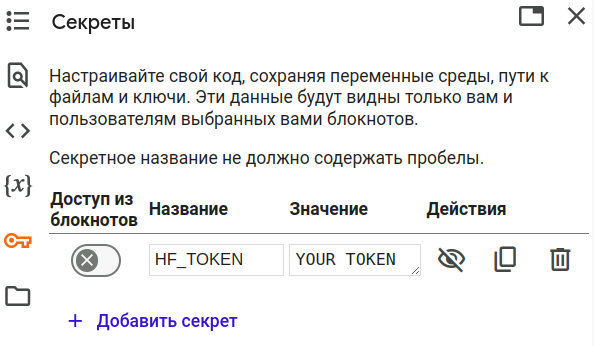

### `Общая подготовка`

In [ ]:
# pip offers the --quiet / -q option to silence output

! pip install transformers[torch] datasets autoawq evaluate seqeval optuna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

При работе с библиотеками часто бывает важно соблюдение версий. Задание тестировалось на Python 3.12 при версиях библиотек указанных ниже.

In [ ]:
!pip freeze > requirements.txt
!cat requirements.txt | grep torch

torch @ https://download.pytorch.org/whl/cu124/torch-2.6.0%2Bcu124-cp311-cp311-linux_x86_64.whl
torchaudio @ https://download.pytorch.org/whl/cu124/torchaudio-2.6.0%2Bcu124-cp311-cp311-linux_x86_64.whl
torchsummary==1.5.1
torchvision @ https://download.pytorch.org/whl/cu124/torchvision-0.21.0%2Bcu124-cp311-cp311-linux_x86_64.whl


In [ ]:
!cat requirements.txt | grep transformers
!cat requirements.txt | grep datasets
!cat requirements.txt | grep autoawq
!cat requirements.txt | grep evaluate
!cat requirements.txt | grep seqeval
!cat requirements.txt | grep optuna

sentence-transformers==3.4.1
transformers==4.50.3
datasets==3.5.0
tensorflow-datasets==4.9.8
vega-datasets==0.9.0
autoawq==0.2.7.post3
evaluate==0.4.3
seqeval==1.2.2
optuna==4.2.1


In [ ]:
import gc
import json
import random
from typing import Any, Union
from pathlib import Path

import numpy as np
import numpy.typing as npt

import torch
import datasets
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TextGenerationPipeline,
    pipeline,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer
)
from transformers.trainer_callback import EarlyStoppingCallback

import optuna
import evaluate

torch.backends.cudnn.benchmark = True
torch.use_deterministic_algorithms(False)

torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
torch.autograd.set_detect_anomaly(False)

torch.set_float32_matmul_precision('high')
torch.backends.cuda.matmul.allow_tf32 = True

In [ ]:
def set_global_seed(seed: int) -> None:
    """Set global seed for reproducibility.
    :param int seed: Seed to be set
    """
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def print_params_count(model):

    total_params = sum(p.numel() for p in model.parameters())
    total_params_grad = sum(p.numel() for p in model.parameters() if p.requires_grad)

    model_name = model.__class__.__name__
    print(f"Информация о числе параметров модели: {model_name}")
    print(f"Всего параметров: \t\t {total_params}")
    print(f"Всего обучаемых параметров: \t {total_params_grad}")
    print()

set_global_seed(42)

На протяжении всего задания вы можете добавлять любой `import`, иногда, это и являются частью задания. При работе с большими библиотеками очень важно уметь читать документацию и использовать гугл для поиска информации.

Для выполнения задания необходимо использование GPU!

In [ ]:
if not torch.cuda.is_available():
    print("You need GPU!!!")

### `Загрузка данных (0.25 балла)`

В первую очередь, Hugging Face --- это хаб с датасетами и моделями. Загрузите готовый датасет [отсюда](https://huggingface.co/datasets/voorhs/conll2003-corrupted).

Подсказка: почитайте [туториал](https://huggingface.co/docs/datasets/load_hub).

*Если не получится сразу, то лучше перед следующими попытками перезапустить ноутбук.*

In [ ]:
from datasets import load_dataset
from datasets import load_dataset_builder

ds_builder = load_dataset_builder("voorhs/conll2003-corrupted")

train_dataset = load_dataset("voorhs/conll2003-corrupted", split="train")
val_dataset = load_dataset("voorhs/conll2003-corrupted", split="validation")
test_dataset = load_dataset("voorhs/conll2003-corrupted", split="test")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.28k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/309k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/281k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [ ]:
print("train:", train_dataset)
print("validation:", val_dataset)
print("test:", test_dataset)

train: Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
    num_rows: 14041
})
validation: Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
    num_rows: 3250
})
test: Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
    num_rows: 3453
})


**Вопрос**: Какие поля нам доступны? Напечатайте пару примеров из каждого сплита. Попытайтесь догадаться какой смысл имеет каждое поле и опишите в двух словах.

*Подсказка:* почитайте [туториал](https://huggingface.co/docs/datasets/access).

In [ ]:
print(train_dataset[0], "\n")
print(val_dataset[0], "\n")
print(test_dataset[0], "\n")
print(ds_builder.info.features["pos_tags"].feature.names, "\n")
print(ds_builder.info.features["chunk_tags"].feature.names, "\n")
print(ds_builder.info.features["ner_tags"], "\n")

{'id': '473', 'tokens': ['LONDON', '1996-08-22'], 'pos_tags': [22, 11], 'chunk_tags': [11, 12], 'ner_tags': ['B-LOC', 'O']} 

{'id': '0', 'tokens': ['CRICKET', '-', 'LEICESTERSHIRE', 'TAKE', 'OVER', 'AT', 'TOP', 'AFTER', 'INNINGS', 'VICTORY', '.'], 'pos_tags': [22, 8, 22, 22, 15, 22, 22, 22, 22, 21, 7], 'chunk_tags': [11, 0, 11, 12, 13, 11, 12, 12, 12, 12, 0], 'ner_tags': ['O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']} 

{'id': '0', 'tokens': ['SOCCER', '-', 'JAPAN', 'GET', 'LUCKY', 'WIN', ',', 'CHINA', 'IN', 'SURPRISE', 'DEFEAT', '.'], 'pos_tags': [21, 8, 22, 37, 22, 22, 6, 22, 15, 12, 21, 7], 'chunk_tags': [11, 0, 11, 21, 11, 12, 0, 11, 13, 11, 12, 0], 'ner_tags': ['O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O']} 

['"', "''", '#', '$', '(', ')', ',', '.', ':', '``', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'NN|SYM', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', '

**Ответ:** *интересно что же вы напишете сюда*

"tokens": список слов в предложении

"pos_tags": части речи.

"chnk_tags": теги, обозначающие синтаксические фразы

"ner_tags": кассификация токенов как именованных сущностей

### `Удаление колонок (0.25 балла)`

Мы будем предсказывать NER tags непосредственно по тексту. Остальная информация нам не понадобится. Удалите все колонки кроме `tokens` и `ner_tags`.

*Подсказка:* почитайте [туториал](https://huggingface.co/docs/datasets/process#remove).

In [ ]:
train_dataset = train_dataset.remove_columns(["id", "pos_tags", "chunk_tags"])
val_dataset = val_dataset.remove_columns(["id", "pos_tags", "chunk_tags"])
test_dataset = test_dataset.remove_columns(["id", "pos_tags", "chunk_tags"])

In [ ]:
print("train:", train_dataset)
print("validation:", val_dataset)
print("test:", test_dataset)

train: Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 14041
})
validation: Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 3250
})
test: Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 3453
})


### `Сбор тегов (0.25 балла)`

Обратите внимание,что в датасете представлена **BIO-разметка**.

**BIO-разметка** -- это способ аннотации текста для распознавания именованных сущностей (NER), где **B** (Beginning) обозначает начало сущности, **I** (Inside) — продолжение той же сущности, а **O** (Outside) — отсутствие сущности.

Например, в предложении *"Apple выпустила новый iPhone"* разметка будет: *"Apple/B-ORG выпустила/O новый/O iPhone/B-PRODUCT"*.

В предложении  *"Билл Гейтс основал Microsoft"* -- *"Билл/B-PER Гейтс/I-PER основал/O Microsoft/B-ORG"*.

**Такой формат помогает моделям точно определять границы и типы сущностей.**



Прежде чем работать с датасетом, необходимо понять, какие именно NER-теги присутствуют в данных. Напечатайте все уникальные значения NER-тегов, которые встречаются в датасете.

*Подсказка:* по датасету можно итерироваться с помощью конструкции `for ... in`

**Вопрос:**
- есть ли какие-то подозрительные теги, которых быть не должно?

In [ ]:
unique_ner_tags = set()

# Итерируемся по всем датасетам
for dataset in [train_dataset, val_dataset, test_dataset]:
    for example in dataset:
        unique_ner_tags.update(example['ner_tags'])

# Выводим уникальные NER-теги
print("Уникальные NER-теги:", sorted(unique_ner_tags))

Уникальные NER-теги: ['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'MISSING', 'O']


Нетипичный тег - 'MISSING'. Возможно, при аннотации данных некоторые теги отсутствовали, и их заполнили временным значением MISSING

Для вычисления лосс функции и подсчета метрик нам потребуется перевести теги в классы, так как мы будем решать задачу классификации.

Создайте мапинги тегов:
- `label2id`: строковое представление тега (например `B-PER`) -> индекс класса
- `id2label`: наоборот

Исключите из них подозрительные теги, которых не должно быть.

*Подсказка:* должно получиться 9 тегов

In [ ]:
unique_ner_tags
good_tags = [label for label in sorted(unique_ner_tags) if label != 'MISSING']
# good_tags
label2id = {label: idx for idx, label in enumerate(good_tags)}
id2label = {idx: label for label, idx in label2id.items()}

print("label2id:", label2id, sep="\n")
print("id2label:", id2label, sep='\n')

label2id:
{'B-LOC': 0, 'B-MISC': 1, 'B-ORG': 2, 'B-PER': 3, 'I-LOC': 4, 'I-MISC': 5, 'I-ORG': 6, 'I-PER': 7, 'O': 8}
id2label:
{0: 'B-LOC', 1: 'B-MISC', 2: 'B-ORG', 3: 'B-PER', 4: 'I-LOC', 5: 'I-MISC', 6: 'I-ORG', 7: 'I-PER', 8: 'O'}


### `Фильтрация (0.25 балла)`

В обучающей выборке для части объектов пропущена разметка. Разделите обучающую выборку на размеченные и неразмеченные объекты. Напечатайте размеры обеих частей.

*Подсказка:* прочитайте [туториал](https://huggingface.co/docs/datasets/process#select-and-filter). Фильрацию датасета можно написать в одну строчку.

In [ ]:
from datasets import DatasetDict


dataset_raw_essential = DatasetDict()
dataset_raw_essential["train"] = train_dataset
dataset_raw_essential["val"] = val_dataset
dataset_raw_essential["test"] = test_dataset

# Объекты с пропущенной разметкой (например, если в тегах есть 'MISSING')
dataset_raw_essential["train_missing"] = dataset_raw_essential["train"].filter(
    lambda x: 'MISSING' in x["ner_tags"])

# Оставшиеся объекты — размеченные
dataset_raw_essential["train"] = dataset_raw_essential["train"].filter(
    lambda x: 'MISSING' not in x["ner_tags"])

print("train:", dataset_raw_essential["train"])
print("validation:", dataset_raw_essential["val"])
print("test:", dataset_raw_essential["test"])
print("train_missing:", dataset_raw_essential["train_missing"])

Filter:   0%|          | 0/14041 [00:00<?, ? examples/s]

Filter:   0%|          | 0/14041 [00:00<?, ? examples/s]

train: Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 10000
})
validation: Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 3250
})
test: Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 3453
})
train_missing: Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 4041
})


In [ ]:
assert len(dataset_raw_essential["train_missing"]) == 4041

### `Получение tokenizer-independent представления (2 балла)`

Имеющаяся BIO-разметка построена для токенизатора, который нам, к сожалению, **не известен**. Необходимо построить tokenizer-independent представление нашего датасета.

**Восстановление текста**: Для каждого объекта датасета необходимо объединить токены из `tokens` в единую строку и поместить в поле `text`. Необходимо учесть, что знаки препинания, кавычки и скобки (например, `,`, `.`, `!`. `)`, `"`) не должны иметь пробелов перед собой, но должны иметь пробел после себя.

**Изменение BIO-разметки**: Так как каждый токенизатор по-своему разобьет полученный `text`, то необходимо уметь строить BIO-разметку для любого токенизатора.

По имеющейся BIO-разметке необходимо:
* Оставить только последовательность сущностей, удалив префиксы начала (B- и I-).
* Для каждой именованной сущности найти позиции символов, ей соответствующие (в формате python slice).

Пример результата:
```python
{
    'text': '6 - Andre Agassi (U.S.) vs. Mauricio Hadad (Colombia)',
    'tags': ['PER', 'LOC', 'PER','LOC'],
    'ranges': [[4, 16], [19, 23], [30, 44], [47, 55]]
}
```

*Пояснение к примеру*. В тексте `'6 - Andre Agassi (U.S.) vs. Mauricio Hadad (Colombia)'` встретилось четыре сущности:
- `PER` на позициях `[4,16]`, а именно `Andre Agassi`
- `LOC` на позициях `[19,23]`, а именно `U.S.`
- `PER` на позициях `[30,44]`, а именно `Mauricio Hadad`
- `LOC` на позициях `[47,55]`, а именно `Colombia`

**Важно:**
- Полученный результат сохраните на диск (например по пути `./data/generic`)
- Подробности о названиях аргументов и возвращаемых значениях берите из докстринга функции `transform_ner_data`

In [ ]:
def transform_ner_data(tokens: list[str], ner_tags: list[str]):
    """
    Obtain tokenizer-independent representation of a single sample.

    Args:
        tokens: list of words, subwords or even punctuations
        ner_tags: list of BIO labels
    Returns:
        sample: dictionary with the following contents:
            - text (str): detokenized sequence
            - tags (list[str]): list of tags names (PER, ORG, LOC, MISC)
            - ranges (list[tuple[int, int]]): list of python slices for each entity
    """

    punctuation_symbols = ("-", "'", ".", ",", ")", ":", ";", '"')

    text = ""
    ranges = []
    tags = []

    current_tag = None
    entity_start = None

    for token, tag in zip(tokens, ner_tags):
        # Определим, добавлять ли пробел
        if len(text) > 0 and not token.startswith(punctuation_symbols):
            text += " "

        token_start = len(text)
        text += token
        token_end = len(text)

        if tag.startswith("B-"):
            # Завершить предыдущую сущность, если была
            if current_tag is not None:
                ranges.append((entity_start, prev_token_end))
                tags.append(current_tag)
            # Начать новую сущность
            current_tag = tag[2:]  # Убираем префикс "B-"
            entity_start = token_start

        elif tag.startswith("I-") and current_tag == tag[2:]:
            # Продолжение текущей сущности — ничего не делаем
            pass

        else:
            # Завершить сущность, если была
            if current_tag is not None:
                ranges.append((entity_start, prev_token_end))
                tags.append(current_tag)
                current_tag = None
                entity_start = None

        prev_token_end = token_end

    # Завершить последнюю сущность, если была
    if current_tag is not None:
        ranges.append((entity_start, token_end))
        tags.append(current_tag)

    return {"text": text, "tags": tags, "ranges": ranges}


Проверьте, что все работает:

In [ ]:
dataset_generic = dataset_raw_essential.map(
    function=transform_ner_data,
    input_columns=["tokens", "ner_tags"],
    remove_columns=dataset_raw_essential["train"].column_names,
)

dataset_generic

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

Map:   0%|          | 0/4041 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 10000
    })
    val: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3453
    })
    train_missing: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 4041
    })
})

In [ ]:
assert dataset_generic["train"][:3] == {
    "text": [
        "LONDON 1996-08-22",
        "WorldCom, which said it will buy MFS, shed 1-3/4 to close at 21 while MFS lost 3-8/16 to close at 41-5/16.",
        "6- Andre Agassi ( U.S.) vs. Mauricio Hadad ( Colombia)",
    ],
    "tags": [["LOC"], ["ORG", "ORG", "ORG"], ["PER", "LOC", "PER", "LOC"]],
    "ranges": [
        [[0, 6]],
        [[0, 8], [33, 36], [70, 73]],
        [[3, 15], [18, 22], [28, 42], [45, 53]],
    ],
}

Сохраните результат на диск (используйте функции из библиотеки `datasets`):

In [ ]:
dataset_generic.save_to_disk("./data/generic")

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3250 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3453 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4041 [00:00<?, ? examples/s]

### `Токенизация (1 балл)`

Для отладки воспользуемся токенизатором модели `google-bert/bert-base-uncased`.

In [ ]:
from transformers import AutoTokenizer

bert_tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
print(bert_tokenizer(dataset_generic["train"]["text"][11]))

{'input_ids': [101, 3078, 3707, 6434, 2001, 27502, 1010, 6352, 11000, 1010, 2403, 1012, 1019, 3867, 2062, 2084, 2197, 2251, 1998, 1014, 1012, 1015, 3867, 2062, 2084, 1999, 2238, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


У каждого токенизатора есть свои специальные токены, для получения этой информации можно воспользоваться соотвествующей переменной.

In [ ]:
bert_tokenizer.all_special_ids

[100, 102, 0, 101, 103]

Теперь надо написать функцию, которая по имеющуемуся tokenizer-independent представлению выдает BIO-разметку для предоставленного токенизатора.  Реализуйте функцию `align_tokens_and_tags`, которая трансформирует один объект из датасета. Все подробности о формате входных данных берите из докстринга.

**Важно:** служебные токены, добавляемые токенизатором должны иметь специальный лейбл `SPECIAL_TOKENS_LABEL`, т.к. их не надо учитывать при сборе лосса.

In [ ]:
SPECIAL_TOKENS_LABEL = -100

def align_tokens_and_tags(
    text: str, tags: list[str], ranges: list[tuple[int, int]], tokenizer
):
    """
    Align the tokenizer-independent representation with a Hugging Face tokenizer.

    Args:
        text: original text.
        tags: list of entity tags (e.g., ["PER", "LOC"]).
        ranges: list of (start, end) character ranges for each entity.
        tokenizer: A Hugging Face tokenizer.

    Returns:
        dict: A dictionary with `input_ids`, `labels`:
            - input_ids are tokens indices in tokenizer's vocabulary
            - labels are integer labels for BIO tags (from label2id mapping)

    Note:
        This function
    """
    encoding = tokenizer(
        text, return_offsets_mapping=True, truncation=True, padding=False
    )
    tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"])
    token_ids = encoding["input_ids"]
    offset_mapping = encoding["offset_mapping"]

    labels = []
    for i, (start_char, end_char) in enumerate(offset_mapping):
        # специальные токены
        if start_char == end_char == 0:
            labels.append(SPECIAL_TOKENS_LABEL)
            continue

        # дефолтные тег
        label = label2id["O"]

        # проверяем попал ли токен в диапазон сущности
        for tag, (ent_start, ent_end) in zip(tags, ranges):
            if end_char <= ent_start or start_char >= ent_end:
                continue  # не попал
            if start_char >= ent_start and end_char <= ent_end:
                prefix = "B-" if start_char == ent_start else "I-"
                label = label2id[f"{prefix}{tag}"]
                break  # берем то, что подошло первым

        labels.append(label)

    return {
        "input_ids": token_ids,
        "labels": labels
    }


In [ ]:
def tokenize_ner_dataset(
    dataset: Union[datasets.DatasetDict, datasets.Dataset], tokenizer: AutoTokenizer
):
    return dataset.map(
        function=align_tokens_and_tags,
        input_columns=["text", "tags", "ranges"],
        fn_kwargs={"tokenizer": tokenizer},
        remove_columns=(
            dataset["train"] if "train" in dataset else dataset
        ).column_names,
    )

Вот пара примеров того, что должно получиться:

In [ ]:
for i in range(9, 12):
    sample = dataset_generic["train"][i]
    print("before tokenization:", sample)
    tokenized_sample = align_tokens_and_tags(**sample, tokenizer=bert_tokenizer)
    print("after tokenization:", tokenized_sample)
    print()

before tokenization: {'text': '1-0.', 'tags': [], 'ranges': []}
after tokenization: {'input_ids': [101, 1015, 1011, 1014, 1012, 102], 'labels': [-100, 8, 8, 8, 8, -100]}

before tokenization: {'text': 'Puchon 3 Chonan 0 ( halftime 1-0)', 'tags': ['ORG', 'ORG'], 'ranges': [[0, 6], [9, 15]]}
after tokenization: {'input_ids': [101, 16405, 24561, 1017, 16480, 7229, 1014, 1006, 22589, 1015, 1011, 1014, 1007, 102], 'labels': [-100, 2, 6, 8, 2, 6, 8, 8, 8, 8, 8, 8, 8, -100]}

before tokenization: {'text': 'Primary iron output was 297,700 tonnes, 14.5 percent more than last July and 0.1 percent more than in June.', 'tags': [], 'ranges': []}
after tokenization: {'input_ids': [101, 3078, 3707, 6434, 2001, 27502, 1010, 6352, 11000, 1010, 2403, 1012, 1019, 3867, 2062, 2084, 2197, 2251, 1998, 1014, 1012, 1015, 3867, 2062, 2084, 1999, 2238, 1012, 102], 'labels': [-100, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, -100]}



Тесты:

In [ ]:
dataset_tokenized = tokenize_ner_dataset(dataset_generic, bert_tokenizer)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

Map:   0%|          | 0/4041 [00:00<?, ? examples/s]

In [ ]:
assert dataset_tokenized["train"][5:7] == {
    "input_ids": [
        [
            101,
            2002,
            2596,
            2000,
            2031,
            2042,
            2730,
            2006,
            9857,
            2305,
            1010,
            6114,
            2012,
            2560,
            2809,
            17079,
            8710,
            1012,
            102,
        ],
        [
            101,
            1023,
            1012,
            13093,
            6178,
            25185,
            1006,
            5706,
            1007,
            8902,
            4877,
            13181,
            2361,
            3590,
            102,
        ],
    ],
    "labels": [
        [-100, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, -100],
        [-100, 8, 8, 3, 7, 7, 8, 0, 8, 2, 6, 6, 6, 8, -100],
    ],
}

## `Часть 2. Доразметка с помощью LLM (2 балла)`

Наконец, обратимся к трансфомерам! Причем сразу к большим.

Мы воспользуемся моделью `Qwen2.5` на 7 миллиардов параметров. Посмотреть актуальный лидерборд различных LLM [можно тут](https://lmarena.ai/). Кроме того, во вкладке direct chat можно пообщаться с различными LLM бесплатно.

### `Промт инжиниринг`

Для удобства парсинга, мы будем просить LLM возвращать ответы сразу в формате `json` словаря.

Напишите промт, в котором перечислите и опишите поля словаря, которые вы хотите получать от LLM.

**Важно:** скорее всего, вы будете возвращаться к этому заданию и редактировать промт, чтобы улучшить качество дальшейших шагов.

*Подсказка:* попросите LLM добавить в словарь отдельное поле `reasoning`, в которую она поместит рассуждения

Для обработки одного примера будем использовать функцию `generate_answer`.

**Важно:** чтобы понимать, как это работает, почитайте [туториал](https://huggingface.co/docs/transformers/main/en/conversations#textgenerationpipeline).

In [ ]:
def messages_maker(text: str) -> list[dict[str, str]]:
    """
    Creates a prompt for the LLM inference to generate NER labels.

    Args:
        text: The input text to be labeled.
    Returns:
        list: A list of messages formatted for the LLM inferemce.
    """
    system_message = (
    "You are an expert in Named Entity Recognition (NER). Your task is to analyze the given text and identify "
    "named entities such as persons (PER), locations (LOC), organizations (ORG), and miscellaneous entities (MISC). "
    "You must return the result as a valid JSON dictionary with the following fields"
    "'text': The original input text provided for labeling.\n"
    "'tags': A list of entity labels for each token in the text, If token not an entity, just ignore them. **Tag 'O' IS NOT ALLOWED**\n"
    "'ranges': A list of [start_char, end_char] pairs for each entity, indicating the positions of the entity in the text. "
    "'reasoning': A detailed explanation of how you identified each entity and why it was assigned the label.\n"
    "Note that 'start_char' and 'end_char' should represent character indices (not token indices). "
    "Please do not use BIO format in your labels. Instead, only list the entity names themselves, such as 'LOC', 'PER', etc., "
    "with no 'B-' or 'I-' prefixes.\n"
    "len(tags) must be equvivalent to tne number of words in the text"
    "Allowed only following tags: ['PER', 'LOC', 'ORG', 'MISC']"
    "Return the response in the following JSON structure:\n"
    "{\n"
    "    'text': 'input text',\n"
    "    'tags': [list of BIO tags],\n"
    "    'ranges': [[start_char_1, end_char_1], [start_char_2, end_char_2], ...],\n"
    "    'reasoning': 'your detailed reasoning here'\n"
    "}\n"
    "IMPORTANT: Your output must be a valid JSON object and contain no extra text or explanation outside the JSON."
    )

    user_message = f"Please analyze the following text and generate the NER labels as described:\n\n{text}"

    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_message},
    ]

    return messages

In [ ]:
def generate_answer(generator: TextGenerationPipeline, query: str) -> str:
    chat = generator(messages_maker(query), max_new_tokens=1024)[0]["generated_text"]
    return chat[-1]["content"]

Эта функция отправляет текстовый запрос `query` большой языковой модели и возвращает ответ:

In [ ]:
from transformers import pipeline


model_name = "Qwen/Qwen2.5-7B-Instruct-AWQ"

generator = pipeline(model=model_name, task="text-generation", device="cuda")
print(type(generator))

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

You have loaded an AWQ model on CPU and have a CUDA device available, make sure to set your model on a GPU device in order to run your model.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/62.7k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.57G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Device set to use cuda


<class 'transformers.pipelines.text_generation.TextGenerationPipeline'>


In [ ]:
print_params_count(generator.model)

Информация о числе параметров модели: Qwen2ForCausalLM
Всего параметров: 		 1090199040
Всего обучаемых параметров: 	 1090199040



In [ ]:
answer1 = generate_answer(generator, "I live in London, but my father is from Germany.")
answer1

'{\n    "text": "I live in London, but my father is from Germany.",\n    "tags": ["O", "O", "LOC", "O", "O", "O", "LOC", "O", "O", "O"],\n    "ranges": [[8, 13], [34, 39]],\n    "reasoning": "London is a city in the UK, so it falls under the LOC category. Germany is also a country, thus categorized as LOC. All other words are not entities."\n}'

In [ ]:
answer2 = generate_answer(generator, "Can't wait the Oasis reunion.")
answer2

'{\n    "text": "Can\'t wait the Oasis reunion.",\n    "tags": ["MISC", "ORG", "MISC"],\n    "ranges": [[8, 14], [15, 19], [23, 27]],\n    "reasoning": "The word \'Oasis\' is recognized as an organization name, which refers to the British rock band. The word\'reunion\' is part of a phrase expressing anticipation for a future event involving the mentioned organization, hence labeled as \'MISC\'. The rest of the words do not denote any specific entities."\n}'

In [ ]:
answer3 = generate_answer(generator, "Check, please.")
answer3

'{\n    "text": "Check, please.",\n    "tags": ["MISC", "MISC"],\n    "ranges": [[0, 5], [7, 12]],\n    "reasoning": "In this sentence, \'Check\' is considered a miscellaneous entity as it can refer to a request for a bill at a restaurant. \'please\' is also considered miscellaneous as it is a common word used in requests without any specific entity reference."\n}'

In [ ]:
answer4 = generate_answer(generator, "Сигма сигма боой сигма боой сигма бой.")
answer4

'{\n    "text": "Sigma sigma boi Sigma boi Sigma boi",\n    "tags": ["MISC", "MISC", "MISC", "MISC", "MISC", "MISC", "MISC", "MISC", "MISC", "MISC"],\n    "ranges": [[0, 5], [7, 12], [14, 19], [21, 26], [28, 33], [35, 40], [42, 47], [49, 54], [56, 61], [63, 68]],\n    "reasoning": "Sigma is considered a MISC entity as it\'s often used as a nickname or username. Boi is also considered a MISC entity as it\'s a slang term often used as a nickname."\n}'

### `Валидация ответов LLM (0.5 балла)`

Ответы LLM не всегда точны. Часто она галлюцинирует или просто делает не то, о чем ее попросили. Поэтому для удобной автоматизации работы с LLM важно уметь валидировать ответы.

1. Проанализируйте ответы LLM из предыдущих ячеек с вызовом `generate_answer` и предположите какие ошибки может делать LLM при генерации ответа.

2. Напишите валидатор, которые будет проверять корректность ответа LLM.

**Вопросы:**
- Какие ошибки LLM можно простить?
- Приведите примеры ошибок (и валидных семплов) и продемонстрируйте работу вашего валидатора

**Важно:** скорее всего, вы будете возвращаться к этому заданию и редактировать промт, чтобы улучшить качество дальшейших шагов.

In [ ]:
import json
import re

def parse_loose_json(text) -> dict:
    cleaned = text.replace('\n', '').strip()

    # Оборачиваем в фигурные скобки, если они отсутствуют
    if not cleaned.startswith('{'):
        cleaned = '{' + cleaned
    if not cleaned.endswith('}'):
        cleaned = cleaned + '}'

    # Убираем лишние запятые перед закрывающей скобкой (на всякий случай)
    cleaned = re.sub(r',\s*}', '}', cleaned)

    try:
        data = json.loads(cleaned)
    except json.JSONDecodeError as e:
        raise ValueError(f"JSON parsing error: {e}\nCleaned text: {cleaned}")

    return data


answer1 = parse_loose_json(answer1)
answer2 = parse_loose_json(answer2)
answer3 = parse_loose_json(answer3)
answer4 = parse_loose_json(answer4)

In [ ]:
def validate(answer: dict) -> bool:
    """
    Validate answer from LLM.

    Args:
        answer: dictionary parsed from LLM output

    Returns:
        bool: True if valid, False otherwise
    """
    valid = True

    # Проверка наличия всех необходимых полей
    required_fields = ['text', 'tags', 'ranges', 'reasoning']
    for field in required_fields:
        if field not in answer:
            print(f"Warning: Missing field '{field}' in the response.")
            valid = False
            break

    # Проверка корректности меток сущностей
    valid_tags = {'LOC', 'PER', 'ORG', 'MISC'}
    for tag in answer.get('tags', []):
        if tag not in valid_tags:
            print(f"Warning: Invalid tag '{tag}' found in tags.")
            valid = False
            break

    # Проверка, что ranges соответствуют длине текста
    for i, (start, end) in enumerate(answer.get('ranges', [])):
        if start < 0 or end > len(answer.get('text', '')):
            print(f"Warning: Range [{start}, {end}] is out of bounds for text of length {len(answer.get('text', ''))}.")
            valid = False
            break

    # Проверка согласованности reasoning и tags
    reasoning_keywords = ['LOC', 'PER', 'ORG', 'MISC']
    for entity in reasoning_keywords:
        if entity in answer.get('reasoning', '') and entity not in answer.get('tags', []):
            print(f"Warning: The entity '{entity}' is mentioned in reasoning but not found in the tags.")
            valid = False
            break

    return valid


In [ ]:
answers = [answer1, answer2, answer3, answer4]

i = 1
for answer in answers:
    is_valid = validate(answer)
    print(f"Answer{i} is valid: {is_valid}")
    i += 1

Answer1 is valid: False
Answer2 is valid: True
Answer3 is valid: True
Answer4 is valid: False


Можно простить ошибки визуальные. Например, если итоговый ответ будет на с 4 полями на разных строчках, а все поля будут на одной строчке. Или если будет неправильное количество знаков переноса строк или табуляциц и т.д.

Также прощаются мелкие логические ошибки. Например, если LLM классифицирует слово как MISC, а не LOC, это может быть оправдано контекстом, и можно принять решение, что это несущественная ошибка.

Нельзя прощать, если какого-то поля не хватает: это критически важно для будущей корректной работы.

Также ошибки неверных диапазонов - если размеченный диапазон больше чем настоящий, это неверно и должно быть исправлено.

### `Обработка ответа LLM (1.5 балла)`

Напишите функцию `generate_ner_labeling`, которая для данного примера
- обращается к LLM чтобы получить разметку (с помощью функции `generate_answer`, определенной ранее)
- парсит ответ LLM в питоновский словарь (с помощью функции `parse`, см. ниже)
- валидирует словарь (с помощью функции `validate`, определенной ранее)
- делает `k_tries` попыток, пока LLM не выдаст валидный ответ

**Важно:** для простоты считайте что в одном тексте одна и та же сущность не повторяется (т.е. "i work at apple and eat an apple" нет в датасете).

*Подсказка:*
- пользуйтесь конструкцией `try except`

Уделите особое внимание следующему вопросу:
- как лучше всего получать `ranges`: просить LLM или пытаться сделать самому?

In [ ]:
def parse(response: str) -> dict[str, Any]:
    """
    Parse LLM's response into dictionary.

    Returns:
        out: dictionary with the arbitrary keys
    """
    start_dict = response.find("{")
    end_dict   = len(response) - response[::-1].find("}") - 1
    return json.loads(response[start_dict : end_dict + 1])

In [ ]:
def generate_ner_labeling(
    text: str, generator: TextGenerationPipeline, k_tries: int = 3
) -> dict:
    """
    Generates NER labeling for the given text using the provided LLM instance.

    Args:
        text: The input text to label.
        llm: The LLM instance for generating NER labels.
        k_tries: Maximum number of attempts to generate valid JSON.

    Returns:
        A dictionary containing 'text', 'tags', 'ranges', 'reasoning' if managed to generate valid samples,
            otherwise dict with 'tags', 'ranges', 'reasoning' are filled with None.
    """
    for _ in range(k_tries):
        try:
            # Запрос к LLM
            response = generate_answer(generator, text)

            # Преобразование строки в словарь
            answer = parse(response)

            # Валидация результата
            if validate(answer):
                print("Succsess!")
                return answer

        except (json.JSONDecodeError, ValueError) as e:
            print(
                f"Invalid JSON or validation error: {e}. Response: {response}. Retrying..."
            )
            continue

        finally:
            gc.collect()
            torch.cuda.empty_cache()

    # YOUR CODE IS HERE
    print(f"Failed to generate valid NER labeling after {k_tries} attempts.")
    return {
        "text": text,
        "tags": None,
        "ranges": None,
        "reasoning": None,
    }

ranges лучше размечать самому. Конечно удобно, что модель может сделать это за тебя, но она может ошибиться и разметить слова по неправиьным символам, выйти за границы предложения, что крайне нежелательно.

Хороший результат должен выглядеть подобным образом:

In [ ]:
generate_ner_labeling("I live in London but my dog Jack doesn't like it.", generator)
generate_ner_labeling("Can't wait the Oasis reunion.", generator)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Failed to generate valid NER labeling after 3 attempts.
Succsess!


{'text': "Can't wait the Oasis reunion.",
 'tags': ['MISC', 'ORG', 'MISC'],
 'ranges': [[7, 13], [14, 19], [21, 28]],
 'reasoning': "The word 'Oasis' is recognized as an organization name, so it is labeled as 'ORG'. The phrase'reunion' is not a specific person or location, but it can be considered a miscellaneous entity related to a fan term or event, hence labeled as 'MISC'. The word 'wait' is not an entity and is ignored."}

Загрузите из памяти ранее рагруженный датасет в tokenizer-independent представлении.

In [ ]:
# YOUR CODE IS HERE
from datasets import load_from_disk

dataset_generic = load_from_disk("./data/generic")
dataset_generic

DatasetDict({
    train: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 10000
    })
    val: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3453
    })
    train_missing: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 4041
    })
})

Мы не можем полноценно разметить 4000+ примеров. Работа LLM на потребительском железе и особенно в облачных средах типа Google Colab и Kaggle очень медленная.

В качестве щадящего режима авторы задания предлагают сделать следующее: доразметить только 10 примеров в пределах от 15 до 30 символов.

In [ ]:
subset_size = 10
min_chars = 15
max_chars = 30

filtered_examples = [ex for ex in dataset_generic["train"]["text"] if min_chars <= len(ex) <= max_chars]
# Выбираем случайные 10 примеров из отфильтрованных
dataset = random.sample(filtered_examples, subset_size)


Приступим к синтезированию!

In [ ]:
synthetic = [generate_ner_labeling(sample, generator) for sample in dataset]

Succsess!
Succsess!
Failed to generate valid NER labeling after 3 attempts.
Succsess!
Succsess!
Failed to generate valid NER labeling after 3 attempts.
Failed to generate valid NER labeling after 3 attempts.
Succsess!
Failed to generate valid NER labeling after 3 attempts.
Failed to generate valid NER labeling after 3 attempts.


Хороший результат должен быть примерно таким:

In [ ]:
synthetic

[{'text': '1996 1995 1996 1995',
  'tags': [],
  'ranges': [],
  'reasoning': 'The text consists of years (1996, 1995) which are not considered named entities in this context. Therefore, there are no entities to tag.'},
 {'text': 'Peter Griffiths',
  'tags': ['PER', 'PER'],
  'ranges': [[0, 5], [6, 13]],
  'reasoning': 'Peter and Griffiths are both names of individuals, thus they are tagged as PER (Person).'},
 {'text': 'Newcastle 21 11 1 9 416 366 23',
  'tags': None,
  'ranges': None,
  'reasoning': None},
 {'text': 'Sion 3 Servette 1',
  'tags': ['LOC', 'MISC', 'ORG', 'MISC'],
  'ranges': [[0, 5], [6, 7], [8, 14], [15, 16]],
  'reasoning': "Sion is a city and thus a location (LOC). '3' is a score and thus miscellaneous (MISC). Servette is a football club and thus an organization (ORG). '1' is another score and thus miscellaneous (MISC)."},
 {'text': 'Shr C$ 0.04 C$ 0.08',
  'tags': [],
  'ranges': [],
  'reasoning': 'The text contains currency symbols and numbers but no named entiti

In [ ]:
valid_synthetic = [ans for ans in synthetic if ans["tags"] is not None]
print(f"number of sucsessfull answers = {len(valid_synthetic)}/{subset_size}")
valid_synthetic

number of sucsessfull answers = 5/10


[{'text': '1996 1995 1996 1995',
  'tags': [],
  'ranges': [],
  'reasoning': 'The text consists of years (1996, 1995) which are not considered named entities in this context. Therefore, there are no entities to tag.'},
 {'text': 'Peter Griffiths',
  'tags': ['PER', 'PER'],
  'ranges': [[0, 5], [6, 13]],
  'reasoning': 'Peter and Griffiths are both names of individuals, thus they are tagged as PER (Person).'},
 {'text': 'Sion 3 Servette 1',
  'tags': ['LOC', 'MISC', 'ORG', 'MISC'],
  'ranges': [[0, 5], [6, 7], [8, 14], [15, 16]],
  'reasoning': "Sion is a city and thus a location (LOC). '3' is a score and thus miscellaneous (MISC). Servette is a football club and thus an organization (ORG). '1' is another score and thus miscellaneous (MISC)."},
 {'text': 'Shr C$ 0.04 C$ 0.08',
  'tags': [],
  'ranges': [],
  'reasoning': 'The text contains currency symbols and numbers but no named entities such as persons, locations, organizations, or miscellaneous entities.'},
 {'text': 'BONN 1996-08-

Результат присоедините к трейновой части нашего `generic` датасета и сохраните результат в папке `generic-synthetic`.

**Важно:** не забудьте отфильтровать неудачные результаты генерации, если они есть (это про случаи когда `k_tries` исчерпались)

In [ ]:
from datasets import Dataset, concatenate_datasets


synthetic_dataset = Dataset.from_list(valid_synthetic)
combined_dataset = concatenate_datasets([dataset_generic["train"], synthetic_dataset])

dataset_generic_synthetic = datasets.DatasetDict({
    "train": dataset_generic["train"],
    "train_LLM": combined_dataset,
    "validation": dataset_generic["val"],
    "test": dataset_generic["test"],
    "train_missing": dataset_generic["train_missing"],
})

dataset_generic_synthetic

DatasetDict({
    train: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 10000
    })
    train_LLM: Dataset({
        features: ['text', 'tags', 'ranges', 'reasoning'],
        num_rows: 10005
    })
    validation: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3453
    })
    train_missing: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 4041
    })
})

In [ ]:
dataset_generic_synthetic.save_to_disk("./data/generic-synthetic")

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10005 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3250 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3453 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4041 [00:00<?, ? examples/s]

Дальше мы не будем использовать генератор, поэтому нам нужно освободить память. Код ниже удалит модельку из памяти:

In [ ]:
del generator
gc.collect()
torch.cuda.empty_cache()

## `Часть 3. Дообучение модели (4 балла)`

Приступим к дообучению модели. Кажется, что наступает самая сложная часть? Действительно, нам предстоит реализовать следующее:
- подсчет лосс функции для каждого токена
- подсчет метрик точности классификации
- встроить это в цикл обучения
- настроить правильное логирование и сохранение чекпоинтов
- желательно подобрать гиперпараметры

На самом деле все просто! `transformers` позволяет реализовать это в два счета благодаря использованию следующих сущностей (все в списке это ссылки на документацию):
- автомодель `AutoModelForTokenClassification` ([документация тут](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForTokenClassification))
- библиотека `evaluate` ([документация тут](https://huggingface.co/docs/evaluate/index))
- класс `DataCollatorForTokenClassification` ([документация тут](https://huggingface.co/docs/transformers/en/main_classes/data_collator#transformers.DataCollatorForTokenClassification))
- интеграция с `optuna` ([документация тут](https://optuna.org/))
- и самое главное, Trainer API в лице `Trainer` ([документация тут](https://huggingface.co/docs/transformers/en/main_classes/trainer#trainer)) и `TrainingArguments` ([документация тут](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments))

### `Токенизация датасета (0.1 балла)`

Токенизируйте датасет с помощью токенизатора модели `BAAI/bge-small-en-v1.5` [документация тут](https://huggingface.co/BAAI/bge-small-en-v1.5) и ранее написанной функции `tokenize_ner_dataset`.

In [ ]:
from transformers import AutoTokenizer

model_name = "BAAI/bge-small-en-v1.5"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Загрузите датасет с диска.

In [ ]:
dataset_synthetic = load_from_disk("./data/generic-synthetic")
dataset_synthetic["train_LLM"] = dataset_synthetic["train_LLM"].remove_columns("reasoning")

dataset_synthetic

DatasetDict({
    train: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 10000
    })
    train_LLM: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 10005
    })
    validation: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3453
    })
    train_missing: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 4041
    })
})

In [ ]:
tokenized_dataset = tokenize_ner_dataset(dataset_synthetic, tokenizer)
tokenized_dataset

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10005 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

Map:   0%|          | 0/4041 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 10000
    })
    train_LLM: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 10005
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 3453
    })
    train_missing: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 4041
    })
})

### `Коллатор (0.1 балла)`

Инициализируйте коллатор и продемонстрируйте его работу.

In [ ]:
from transformers import DataCollatorForLanguageModeling, BertTokenizer


collator = DataCollatorForTokenClassification(tokenizer=tokenizer, padding=True)


In [ ]:
batch = collator([tokenized_dataset["train"][i] for i in range(2)])
batch["labels"]

tensor([[-100,    0,    8,    8,    8,    8,    8, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100],
        [-100,    2,    6,    8,    8,    8,    8,    8,    8,    2,    6,    8,
            8,    8,    8,    8,    8,    8,    8,    8,    8,    8,    8,    2,
            6,    8,    8,    8,    8,    8,    8,    8,    8,    8,    8,    8,
            8,    8,    8,    8, -100]])

### `Метрики (0.8 балла)`

Библиотека `evaluate` ([документация тут](https://huggingface.co/docs/evaluate/index)) предоставляет набор популярных метрик для NLP. Метрики для `NER` можно загрузить следующей командой:

In [ ]:
import evaluate

metric = evaluate.load("seqeval")

Эта метрика работает с BIO разметкой в текстовом представлении:

In [ ]:
metric.compute(
    predictions=[["O", "B-PER", "O", "O"]], references=[["O", "B-PER", "I-PER", "O"]]
)

{'PER': {'precision': np.float64(0.0),
  'recall': np.float64(0.0),
  'f1': np.float64(0.0),
  'number': np.int64(1)},
 'overall_precision': np.float64(0.0),
 'overall_recall': np.float64(0.0),
 'overall_f1': np.float64(0.0),
 'overall_accuracy': 0.75}

In [ ]:
metric.compute(
    predictions=[["O", "B-PER", "B-ORG", "O"]],
    references=[["O", "B-PER", "I-PER", "B-ORG"]],
)

{'ORG': {'precision': np.float64(0.0),
  'recall': np.float64(0.0),
  'f1': np.float64(0.0),
  'number': np.int64(1)},
 'PER': {'precision': np.float64(0.0),
  'recall': np.float64(0.0),
  'f1': np.float64(0.0),
  'number': np.int64(1)},
 'overall_precision': np.float64(0.0),
 'overall_recall': np.float64(0.0),
 'overall_f1': np.float64(0.0),
 'overall_accuracy': 0.5}

Реализуйте функцию `compute_metrics`.

In [ ]:
def compute_metrics(
    eval_preds: tuple[npt.NDArray, list[list[int]]],
) -> dict[str, float]:
    """
    Compute metrics on given batch.

    Args:
        eval_preds: tuple with the following contents:
            - logits: array of shape `(batch_size, seq_length, n_classes)`,
            - labels: list of lists, i.e. matrix of shape `(batch_size, seq_length)`
    Returns:
        metrics: dictionary with metrics calculated over all classes:
            - precision
            - recall
            - f1
            - accuracy
    """
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Преобразуем индексы в текстовые метки, игнорируя -100
    true_labels = []
    true_predictions = []

    for pred, label in zip(predictions, labels):
        pred_labels = []
        label_labels = []

        for p, l in zip(pred, label):
            if l != -100:
                pred_labels.append(id2label[p])
                label_labels.append(id2label[l])

        true_predictions.append(pred_labels)
        true_labels.append(label_labels)

    # Вычисляем метрики
    results = metric.compute(predictions=true_predictions, references=true_labels)

    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

### `Построение модели`

In [ ]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    model_name, id2label=id2label, label2id=label2id
)

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Обратите внимание на её структуру --- `transformers` автоматически добавил `classifier` с нужным числом классов:

In [ ]:
model

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-12

In [ ]:
print_params_count(model)

Информация о числе параметров модели: BertForTokenClassification
Всего параметров: 		 33215625
Всего обучаемых параметров: 	 33215625



### `Обучение (1 балл)`

Ниже представлен базовый код для обучения модели:

In [ ]:
from transformers import TrainingArguments

args = TrainingArguments(
    "data/bert-finetuned-ner",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=collator,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
)

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: keiiino (keiiino_) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.220900,0.139370,0.808932,0.865702,0.836355,0.969530
2,0.109500,0.101288,0.859073,0.898687,0.878434,0.976822
3,0.080600,0.095422,0.866077,0.906597,0.885874,0.977823


TrainOutput(global_step=3750, training_loss=0.1787730982462565, metrics={'train_runtime': 244.5089, 'train_samples_per_second': 122.695, 'train_steps_per_second': 15.337, 'total_flos': 158919761119392.0, 'train_loss': 0.1787730982462565, 'epoch': 3.0})

Благодаря простому интерфейсу обучения разработчик может сместить фокус своих усилий с написания трейн лупа на решение более высокоуровневых задач.

Модифицируйте `Trainer` ([документация тут](https://huggingface.co/docs/transformers/en/main_classes/trainer#trainer)) и `TrainingArguments`([документация тут](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments)) следующим образом:
- должно происходить логирование в `wandb`
- должен срабатывать ранний останов обучения, если качество перестало расти (подберите параметры на ваше усмотрение)
- лучший чекпоинт загружается в публичный репозиторий на `hugging face hub`

Добавьте в ячейку ниже ссылку на свой `wandb` отчет и ссылку на свой репозиторий `hugging face hub`.

- **Отчет wandb**: https://wandb.ai/keiiino_/ner-bert-project?nw=nwuserkeiiino
- **Репозиторий hf**: https://huggingface.co/Keiiino/bert-finetuned-ner

In [81]:
from huggingface_hub import login
login()

In [83]:
import wandb
from transformers import EarlyStoppingCallback

wandb.init(project="ner-token-classification", name="ner-finetuning", config={"visibility": "public"})

args = TrainingArguments(
    "data/bert-finetuned-ner",
    eval_strategy="steps",
    save_strategy="steps",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="wandb",
    run_name="ner-finetuning",
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
)

early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=2,
    early_stopping_threshold=0.003,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[early_stopping_callback],
)

trainer.train()

wandb.finish()
trainer.push_to_hub("best_model")

<ipython-input-83-d84327b77146>:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
500,0.077100,0.093239,0.871072,0.909626,0.889932,0.978093
1000,0.063200,0.087112,0.880546,0.911814,0.895907,0.979538
1500,0.049400,0.088834,0.883439,0.918378,0.900569,0.979745
2000,0.040900,0.086225,0.884959,0.917873,0.901115,0.980094
2500,0.044200,0.087095,0.890868,0.917704,0.904087,0.979999


eval/accuracy,▁▆▇██
eval/f1,▁▄▆▇█
eval/loss,█▂▄▁▂
eval/precision,▁▄▅▆█
eval/recall,▁▃██▇
eval/runtime,█▁▁▃█
eval/samples_per_second,▁██▆▁
eval/steps_per_second,▁██▆▁
train/epoch,▁▁▃▃▅▅▆▆███
train/global_step,▁▁▃▃▅▅▆▆███
train/grad_norm,█▅█▁▁


events.out.tfevents.1744312450.15d279547a45.217.0:   0%|          | 0.00/8.62k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/Keiiino/bert-finetuned-ner/commit/43c8801e0b8257076ec042c280fbdac0198a60b1', commit_message='best_model', commit_description='', oid='43c8801e0b8257076ec042c280fbdac0198a60b1', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Keiiino/bert-finetuned-ner', endpoint='https://huggingface.co', repo_type='model', repo_id='Keiiino/bert-finetuned-ner'), pr_revision=None, pr_num=None)

### `Перебор гиперпараметров (1 балл)`

Trainer API обладает интеграцией с `optuna` -- инструментом для перебора гиперпараметров в машинном обучении. Реализуйте перебор следующих гиперпараметров:
- `learning_rate` от `1e-6` до `1e-4` в логарифмическом масштабе
- `per_device_train_batch_size` среди `[4, 8, 16, 32]`

Учтите что поиск гиперпараметров лучше производить на маленькой порции трейна (возьмите 2048 случайных примеров), а метрику лучше считать на маленькой порции валидации (возьмите 512 случайных примеров).

Подробный [туториал](https://huggingface.co/docs/transformers/hpo_train).

In [105]:
from optuna import Trial

def optuna_hp_space(trial: optuna.Trial) -> dict:
    return {
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-6, 1e-4),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [4, 8, 16, 32]),
    }

dataset_generic

DatasetDict({
    train: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 10000
    })
    val: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3453
    })
    train_missing: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 4041
    })
})

In [110]:
from optuna import Trial

def model_init(trial: Trial):
    return AutoModelForTokenClassification.from_pretrained(
        model_name, id2label=id2label, label2id=label2id
    )

# tokenized_dataset

small_train_dataset = tokenized_dataset["train"].shuffle(seed=42).select(range(2048))
small_eval_dataset  = tokenized_dataset["validation"].shuffle(seed=42).select(range(512))

In [111]:
print(small_train_dataset)
print(small_eval_dataset)

Dataset({
    features: ['input_ids', 'labels'],
    num_rows: 2048
})
Dataset({
    features: ['input_ids', 'labels'],
    num_rows: 512
})


In [112]:
from transformers.trainer_callback import EarlyStoppingCallback

args = TrainingArguments(
    "data/bert-finetuned-ner",
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False,
    metric_for_best_model="eval_f1",
    eval_strategy="epoch",
    remove_unused_columns=False,
)

trainer = Trainer(
    model=None,
    args=args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
    model_init=model_init,
    data_collator=collator,
    callbacks=[EarlyStoppingCallback()],
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [102]:
from optuna.samplers import TPESampler

sampler = TPESampler(seed=42)

In [103]:
def compute_objective(eval_results: dict[str, float]) -> float:
    return eval_results["eval_f1"]

In [113]:
# time ~ 15 minutes

best_trial = trainer.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    hp_space=optuna_hp_space,
    n_trials=20,
    sampler=sampler,
    compute_objective=compute_objective,
)

[I 2025-04-10 20:14:36,552] A new study created in memory with name: no-name-d0c791c3-dafb-40ba-b608-78a98654d617
<ipython-input-105-a5ccb9d7a848>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-6, 1e-4),
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,1.092803,0.000000,0.000000,0.000000,0.791108
2,1.327100,0.882484,0.000000,0.000000,0.000000,0.791108


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are i

eval/accuracy,▁▁
eval/f1,▁▁
eval/loss,█▁
eval/precision,▁▁
eval/recall,▁▁
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁███
train/global_step,▁███
train/grad_norm,▁


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.724100,1.163496,0.000000,0.000000,0.000000,0.791108
2,1.017300,0.904285,0.000000,0.000000,0.000000,0.791108


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are i

eval/accuracy,▁▁
eval/f1,▁▁
eval/loss,█▁
eval/precision,▁▁
eval/recall,▁▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁███
train/global_step,▁▁███
train/grad_norm,█▁


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,1.002870,0.000000,0.000000,0.000000,0.791108
2,1.266900,0.857838,0.000000,0.000000,0.000000,0.791108


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-10 20:17:18,576] Trial 2 finished with value: 0.0 and parameters: {'learning_rate': 2.3270677083837795e-06, 'per_device_train_batch_size': 8}. Best is trial 0 with value: 0.0.
<ipython-input-105-a5ccb9d7a848>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=T

eval/accuracy,▁▁
eval/f1,▁▁
eval/loss,█▁
eval/precision,▁▁
eval/recall,▁▁
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁███
train/global_step,▁███
train/grad_norm,▁


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.832167,0.000000,0.000000,0.000000,0.791108
2,No log,0.600719,0.266779,0.173961,0.210596,0.849495
3,No log,0.559298,0.334868,0.318381,0.326416,0.854962


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-10 20:17:54,649] Trial 3 finished with value: 0.32641615255187884 and parameters: {'learning_rate': 1.6738085788752145e-05, 'per_device_train_batch_size': 32}. Best is trial 3 with value: 0.32641615255187884.
<ipython-input-105-a5ccb9d7a848>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-6, 1e-4),
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'clas

eval/accuracy,▁▇█
eval/f1,▁▆█
eval/loss,█▂▁
eval/precision,▁▇█
eval/recall,▁▅█
eval/runtime,█▆▁
eval/samples_per_second,▁▂█
eval/steps_per_second,▁▂█
train/epoch,▁▅██
train/global_step,▁▅██
eval/accuracy,0.85496


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.383033,0.461111,0.544858,0.499498,0.915618
2,No log,0.249139,0.657172,0.706783,0.681075,0.949660
3,No log,0.228143,0.676737,0.735230,0.704772,0.951516


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-10 20:18:34,536] Trial 4 finished with value: 0.7047718930256948 and parameters: {'learning_rate': 3.718364180573207e-05, 'per_device_train_batch_size': 16}. Best is trial 4 with value: 0.7047718930256948.
<ipython-input-105-a5ccb9d7a848>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-6, 1e-4),
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classif

eval/accuracy,▁██
eval/f1,▁▇█
eval/loss,█▂▁
eval/precision,▁▇█
eval/recall,▁▇█
eval/runtime,▂▁█
eval/samples_per_second,▇█▁
eval/steps_per_second,▇█▁
train/epoch,▁▅██
train/global_step,▁▅██
eval/accuracy,0.95152


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.836206,0.000000,0.000000,0.000000,0.791108
2,No log,0.607704,0.214545,0.129103,0.161202,0.846400


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-10 20:18:50,998] Trial 5 pruned. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁█
eval/f1,▁█
eval/loss,█▁
eval/precision,▁█
eval/recall,▁█
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁█
train/global_step,▁█
eval/accuracy,0.8464


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.350452,0.523992,0.597374,0.558282,0.929131
2,No log,0.231021,0.681026,0.726477,0.703017,0.953580
3,No log,0.211663,0.689024,0.741794,0.714436,0.952857


[I 2025-04-10 20:19:23,483] Trial 6 finished with value: 0.714436248682824 and parameters: {'learning_rate': 4.138040112561016e-05, 'per_device_train_batch_size': 16}. Best is trial 6 with value: 0.714436248682824.
<ipython-input-105-a5ccb9d7a848>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-6, 1e-4),
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁██
eval/f1,▁▇█
eval/loss,█▂▁
eval/precision,▁██
eval/recall,▁▇█
eval/runtime,▁▄█
eval/samples_per_second,█▅▁
eval/steps_per_second,█▅▁
train/epoch,▁▅██
train/global_step,▁▅██
eval/accuracy,0.95286


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,1.728337,0.016393,0.003282,0.005469,0.778316


[I 2025-04-10 20:19:36,773] Trial 7 pruned. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.77832


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.528033,0.373507,0.376368,0.374932,0.863008


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-10 20:19:50,944] Trial 8 pruned. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.86301


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.192610,0.754655,0.753829,0.754242,0.956158
2,0.295500,0.144204,0.771169,0.836980,0.802728,0.964411
3,0.295500,0.129662,0.827443,0.870897,0.848614,0.970497


[I 2025-04-10 20:20:46,256] Trial 9 finished with value: 0.8486140724946696 and parameters: {'learning_rate': 8.692991511139554e-05, 'per_device_train_batch_size': 8}. Best is trial 9 with value: 0.8486140724946696.
<ipython-input-105-a5ccb9d7a848>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-6, 1e-4),
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▅█
eval/f1,▁▅█
eval/loss,█▃▁
eval/precision,▁▃█
eval/recall,▁▆█
eval/runtime,▆▁█
eval/samples_per_second,▂█▁
eval/steps_per_second,▂█▁
train/epoch,▁▄▅██
train/global_step,▁▄▅██
train/grad_norm,▁


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.186791,0.739891,0.740700,0.740295,0.952857
2,0.294400,0.137763,0.773604,0.833698,0.802528,0.965855
3,0.294400,0.121512,0.827801,0.873085,0.849840,0.971219


[I 2025-04-10 20:21:37,968] Trial 10 finished with value: 0.8498402555910544 and parameters: {'learning_rate': 9.098956894049806e-05, 'per_device_train_batch_size': 8}. Best is trial 10 with value: 0.8498402555910544.
<ipython-input-105-a5ccb9d7a848>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-6, 1e-4),
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆█
eval/f1,▁▅█
eval/loss,█▃▁
eval/precision,▁▄█
eval/recall,▁▆█
eval/runtime,▁▁█
eval/samples_per_second,██▁
eval/steps_per_second,██▁
train/epoch,▁▄▅██
train/global_step,▁▄▅██
train/grad_norm,▁


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.192500,0.751369,0.750547,0.750958,0.955024
2,0.294900,0.139225,0.787018,0.849015,0.816842,0.966474
3,0.294900,0.127338,0.834555,0.871991,0.852862,0.970807


[I 2025-04-10 20:22:32,504] Trial 11 finished with value: 0.8528624933119315 and parameters: {'learning_rate': 8.691089486124968e-05, 'per_device_train_batch_size': 8}. Best is trial 11 with value: 0.8528624933119315.
<ipython-input-105-a5ccb9d7a848>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-6, 1e-4),
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆█
eval/f1,▁▆█
eval/loss,█▂▁
eval/precision,▁▄█
eval/recall,▁▇█
eval/runtime,▁█▂
eval/samples_per_second,█▁▆
eval/steps_per_second,█▁▆
train/epoch,▁▄▅██
train/global_step,▁▄▅██
train/grad_norm,▁


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.183165,0.774159,0.780088,0.777112,0.960388
2,0.289700,0.142509,0.790506,0.838074,0.813595,0.965339
3,0.289700,0.123134,0.843717,0.874179,0.858678,0.972148


[I 2025-04-10 20:23:23,962] Trial 12 finished with value: 0.8586781300376142 and parameters: {'learning_rate': 9.592790497192444e-05, 'per_device_train_batch_size': 8}. Best is trial 12 with value: 0.8586781300376142.
<ipython-input-105-a5ccb9d7a848>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-6, 1e-4),
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▄█
eval/f1,▁▄█
eval/loss,█▃▁
eval/precision,▁▃█
eval/recall,▁▅█
eval/runtime,▃▁█
eval/samples_per_second,▆█▁
eval/steps_per_second,▆█▁
train/epoch,▁▄▅██
train/global_step,▁▄▅██
train/grad_norm,▁


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.777124,0.000000,0.000000,0.000000,0.791108


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-10 20:23:40,311] Trial 13 pruned. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.79111


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.411800,0.177953,0.793893,0.796499,0.795194,0.961523


[I 2025-04-10 20:24:12,297] Trial 14 pruned. 
<ipython-input-105-a5ccb9d7a848>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-6, 1e-4),
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁█
train/global_step,▁█
train/grad_norm,▁


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.623983,0.137755,0.059081,0.082695,0.831958


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-10 20:24:27,570] Trial 15 pruned. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.83196


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.209789,0.697773,0.719912,0.708670,0.952445


[I 2025-04-10 20:24:42,859] Trial 16 pruned. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.95244


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.324434,0.527831,0.601751,0.562372,0.930885


[I 2025-04-10 20:24:59,521] Trial 17 pruned. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.93089


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.341500,0.145171,0.791889,0.811816,0.801729,0.964514


[I 2025-04-10 20:25:38,182] Trial 18 pruned. 
<ipython-input-105-a5ccb9d7a848>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-6, 1e-4),
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁█
train/global_step,▁█
train/grad_norm,▁


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.940823,0.000000,0.000000,0.000000,0.791108
2,No log,0.815794,0.000000,0.000000,0.000000,0.791108


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-10 20:25:55,678] Trial 19 pruned. 


Чтобы посмотреть лучшие гиперпараметры, достаточно обратиться к соответствующему атрибуту. У вас, скорее всего, будут другие результаты, но похожие.

In [114]:
best_trial.hyperparameters

{'learning_rate': 9.592790497192444e-05, 'per_device_train_batch_size': 8}

Кроме того, мы можем посмотреть на значение метрики на лучшем запуске.

In [115]:
best_trial.objective

0.8586781300376142

### `Есть ли польза от доразметки (1 балл)`

Обучите NER модель с подобранными гиперпараметрами на датасете с доразмеченной частью и без. Дала ли доразметка значимый прирост? Прикрепите ссылку на wandb.

**Ссылка на wandb раны:** *you link*

In [127]:
# ЗДЕСЬ УЖЕ РАЗМЕЧЕННЫЕ ДАННЫЕ

wandb.init(project="ner-bert-project", name="baseline")

args = TrainingArguments(
    "data/bert-finetuned-ner",
    eval_strategy="epoch",
    save_strategy="epoch",
    weight_decay=0.01,
    **best_trial.hyperparameters,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=collator,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
)

trainer.train()
wandb.finish()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.063600,0.106350,0.863578,0.912992,0.887598,0.976266
2,0.038200,0.088215,0.902927,0.918883,0.910835,0.980507
3,0.025200,0.081145,0.901245,0.926119,0.913513,0.981572


eval/accuracy,▁▇█
eval/f1,▁▇█
eval/loss,█▃▁
eval/precision,▁██
eval/recall,▁▄█
eval/runtime,▁▅█
eval/samples_per_second,█▄▁
eval/steps_per_second,█▄▁
train/epoch,▁▂▃▃▄▅▅▆▇██
train/global_step,▁▂▃▃▄▅▅▆▇██
train/grad_norm,▁▁▆█▁▁▁


Обучим модель с лучшими параметрами, чтобы иметь бейзлайн с которым будем сравниваться.

In [142]:
from datasets import concatenate_datasets, DatasetDict

# Приводим train_missing к той же схеме, что и train
train_missing_casted = dataset_generic["train_missing"].cast(dataset_generic["train"].features)

# Объединяем
combined_train = concatenate_datasets([
    dataset_generic["train"],
    train_missing_casted
])

# Новый DatasetDict
dataset = DatasetDict({
    "train": combined_train,
    "val": dataset_generic["val"],
    "test": dataset_generic["test"],
})

tokenized_unlabeled_data = tokenize_ner_dataset(dataset, tokenizer)

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [143]:
tokenized_unlabeled_data

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 14041
    })
    val: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 3453
    })
})

In [144]:
# НЕРАЗМЕЧЕННЫЕ ДАННЫЕ

args = TrainingArguments(
    "data/bert-finetuned-ner",
    eval_strategy="epoch",
    save_strategy="epoch",
    weight_decay=0.01,
    **best_trial.hyperparameters,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_unlabeled_data["train"],
    eval_dataset=tokenized_unlabeled_data["val"],
    data_collator=collator,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
)

In [145]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.173300,0.159029,0.909879,0.900539,0.905185,0.977505
2,0.144600,0.163991,0.890653,0.849882,0.869790,0.965860
3,0.122000,0.191283,0.919364,0.798216,0.854518,0.954676


TrainOutput(global_step=5268, training_loss=0.14789686441964603, metrics={'train_runtime': 288.4538, 'train_samples_per_second': 146.03, 'train_steps_per_second': 18.263, 'total_flos': 223592152488768.0, 'train_loss': 0.14789686441964603, 'epoch': 3.0})

Загрузим датасет с диска.

Ваше мини исследование о том, как влияет доразметка на результаты обучения.

*Нет необходимости делать слишком много разных запусков, запустите обучение и сравните результаты*

**Без выводов пункт не будет засчитан**

**Ваши выводы:** Доразметка приводит к росту метрик. Не очень сильно, но прилично, чтобы иметь значение. Особенно повышает полноту (Recall), что критично для многих задач NER. Такой прирост может быть особенно важен, если цель — максимально "поймать" все сущности.

Мы очень будем рады, если здесь напишите ваше впечатление о задании!

*Обратная связь:*




Задание хорошее, не муторное, приятное. Оно конечно намного, намного легче чем все остальное, но если бы на нашем курсе все задания были бы такими, мир стал бы чуточку счастливие :)

Проекты я пока не нашла как сделать публичными, сделаю это после отправки задания, чтобы в очередной раз себя не задерживать, ссылку отдельно прикрпелю в anytask